In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from claspy.data_loader import load_tssb_dataset, tssb_dataset_names
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.tests.evaluation import covering

In [2]:
tssb = load_tssb_dataset()
tssb

,dataset,window_size,cps,time_series
0,Adiac,10,"[572, 1012, 1232]","[1.681146, 1.383394, 1.029389, 0.688386, 0.354..."
1,ArrowHead,10,[753],"[-1.957721, -1.858082, -1.657983, -1.420794, -..."
2,Beef,50,[705],"[-0.380818, -0.352238, -0.295392, -0.225041, -..."
3,BeetleFly,10,[1280],"[1.114805, 0.774403, 0.477129, 0.115781, -0.24..."
4,BirdChicken,20,[1280],"[1.697714, 1.439032, 1.22287, 0.99708, 0.76479..."
...,...,...,...,...
70,UWaveGestureLibraryX,10,"[600, 1131, 1652, 2193]","[-0.889766, 0.722005, 0.869297, -0.553167, -0...."
71,UWaveGestureLibraryY,10,"[600, 1131, 1652, 2193]","[-1.523467, -0.106794, 0.190361, 0.979247, 0.3..."
72,UWaveGestureLibraryZ,10,"[600, 1131, 1652, 2193]","[-0.527058, 0.416111, -0.524027, 0.41141, 0.12..."
73,WordSynonyms,10,"[202, 2227]","[-1.183581, -0.514028, -0.480539, -0.394855, -..."


# Setting up the oracle

Function that calculates the covering scores for each time series in the ```tssb``` using ClaSP with the specified distance measure. Options are
- znormed_euclidean_distance
- cinvariant_euclidean_distance
- euclidean_distance

In [3]:
def covering_scores_for_dist(dist: str) -> list[float]:
    cov_scores = []
    for idx, (dataset, window_size, cps, time_series) in list(tssb.iterrows()):
        clasp = BinaryClaSPSegmentation(distance=dist)
        found_cps = clasp.fit_predict(time_series)
        set_score = float(np.round(covering({0: cps}, found_cps, time_series.shape[0]), 5))
        cov_scores.append(set_score)
    return cov_scores

In [4]:
dist_measures = ["znormed_euclidean_distance", "cinvariant_euclidean_distance", "euclidean_distance"]

cov_path = "./cov_scores.csv"
if os.path.exists(cov_path):
    df = pd.read_csv(cov_path)
else:
    df = pd.DataFrame()

    for dm in dist_measures:
        scores = covering_scores_for_dist(dm)
        df[dm] = scores

    df.to_csv(cov_path, index=False)
df

,znormed_euclidean_distance,cinvariant_euclidean_distance,euclidean_distance
0,0.80744,0.93578,0.94104
1,0.98550,0.98681,0.98681
2,0.97340,0.80260,0.80260
3,0.97530,0.66069,0.65420
4,0.99377,0.54570,0.54453
...,...,...,...
70,0.98663,0.98734,0.90162
71,0.96282,0.96206,0.95946
72,0.81048,0.79963,0.80961
73,0.72692,0.83742,0.72692


In [5]:
znorm = float(np.round(df["znormed_euclidean_distance"].mean(), 5))
cinv  = float(np.round(df["cinvariant_euclidean_distance"].mean(), 5))
euc   = float(np.round(df["euclidean_distance"].mean(), 5))

znorm, cinv, euc

(0.85508, 0.85808, 0.84063)

Now that we have all scores for each distance measure, we can implement the oracle.

In [6]:
t_oracle = df.idxmax(axis="columns")
t_oracle = t_oracle.to_list()
oracle = dict(zip(tssb_dataset_names, t_oracle))

ds_names = dict(zip(tssb_dataset_names, list(range(len(tssb_dataset_names)))))

ds_names["Adiac"], oracle["Adiac"]

(0, 'euclidean_distance')

In [7]:
def oracle_score(dataset, verbose=False):
    if verbose:
        return df.loc[ds_names[dataset], oracle[dataset]], oracle[dataset]    
    else:
        return df.loc[ds_names[dataset], oracle[dataset]]

oracle_score("Adiac"), oracle_score("Adiac", verbose=True)

(np.float64(0.94104), (np.float64(0.94104), 'euclidean_distance'))

In [8]:
optimum = np.empty(len(tssb_dataset_names))
for i, ds in enumerate(tssb_dataset_names):
    optimum[i] = oracle_score(ds)

optimum.mean()

np.float64(0.8928487999999999)

In [9]:
optimum

array([0.94104, 0.98681, 0.9734 , 0.9753 , 0.99377, 0.90001, 0.97935,
       1.     , 0.57749, 0.79315, 0.99402, 0.70618, 0.98719, 0.97566,
       0.98685, 0.98479, 0.86768, 0.94501, 0.76772, 1.     , 0.9744 ,
       0.9949 , 0.41884, 0.57067, 0.89663, 0.97506, 0.91023, 0.99157,
       0.98847, 0.91323, 0.25053, 1.     , 0.99256, 0.35642, 0.71262,
       0.95884, 0.98887, 0.98847, 0.99498, 0.97441, 0.99099, 0.51379,
       0.98641, 0.98907, 0.79698, 0.99497, 1.     , 0.99762, 0.9947 ,
       0.99562, 0.84195, 0.99044, 0.95591, 0.92229, 0.94108, 0.99153,
       0.98736, 1.     , 0.98155, 0.9864 , 0.46682, 0.88291, 0.8822 ,
       0.99362, 0.84985, 0.99097, 0.97366, 0.50099, 1.     , 0.9967 ,
       0.98734, 0.96282, 0.81048, 0.83742, 0.7821 ])

In [10]:
dataset_scores = pd.concat([tssb.dataset, df], axis=1)
dataset_scores

,dataset,znormed_euclidean_distance,cinvariant_euclidean_distance,euclidean_distance
0,Adiac,0.80744,0.93578,0.94104
1,ArrowHead,0.98550,0.98681,0.98681
2,Beef,0.97340,0.80260,0.80260
3,BeetleFly,0.97530,0.66069,0.65420
4,BirdChicken,0.99377,0.54570,0.54453
...,...,...,...,...
70,UWaveGestureLibraryX,0.98663,0.98734,0.90162
71,UWaveGestureLibraryY,0.96282,0.96206,0.95946
72,UWaveGestureLibraryZ,0.81048,0.79963,0.80961
73,WordSynonyms,0.72692,0.83742,0.72692


In [11]:
def time_series(dataset):
    return tssb.loc[tssb.dataset == dataset].time_series.tolist()[0]

time_series("BeetleFly")

array([1.114805, 0.774403, 0.477129, ..., 0.094708, 0.584328, 1.118003],
      shape=(2560,))

In [12]:
def sliding_mean_stddev(ts, w_size):
    means = np.zeros(len(ts) - w_size + 1)
    means[0] = float(np.sum(ts[:w_size])) / float(w_size)
    
    var = np.zeros(len(ts) - w_size + 1)
    var[0] = np.sum(np.square(ts[:w_size] - means[0])) / float(w_size)

    for i in range(1, len(ts) - w_size + 1):
        means[i] = means[i - 1] - (ts[i - 1] / w_size) + (ts[i - 1 + w_size] / w_size)
        var[i] = np.sum(np.square(ts[i:i + w_size] - means[i])) / float(w_size)
    return means, np.sqrt(var)

t = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sliding_mean_stddev(t, 3)

(array([2., 3., 4., 5., 6., 7., 8., 9.]),
 array([0.81649658, 0.81649658, 0.81649658, 0.81649658, 0.81649658,
        0.81649658, 0.81649658, 0.81649658]))

### Let's look at some time series for which the z-normalized Euclidean distance significantly outperforms the Euclidean distance.

In [13]:
dataset_scores[2:5]

,dataset,znormed_euclidean_distance,cinvariant_euclidean_distance,euclidean_distance
2,Beef,0.97340,0.80260,0.80260
3,BeetleFly,0.97530,0.66069,0.65420
4,BirdChicken,0.99377,0.54570,0.54453


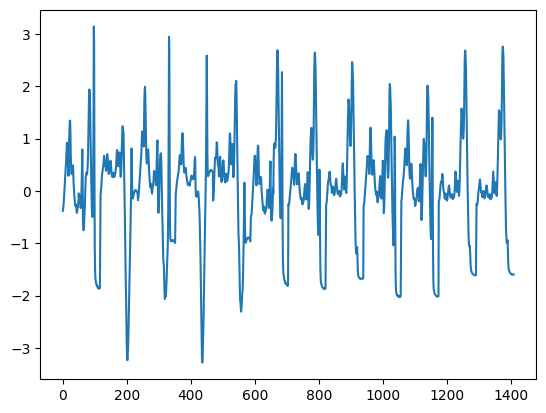

In [14]:
beef_ts = time_series("Beef")
plt.plot(beef_ts)

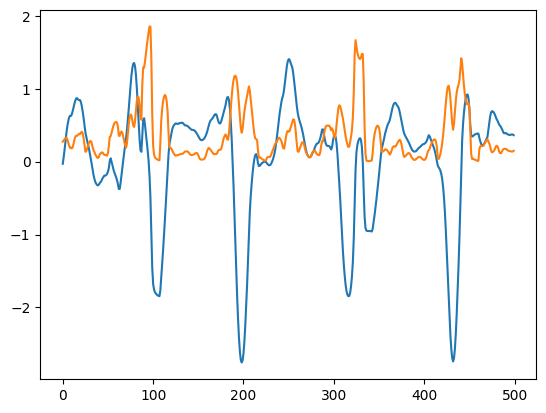

In [15]:
beef_mu, beef_sigma = sliding_mean_stddev(beef_ts, 10)

view_len = 500
plt.plot(beef_mu[:view_len])     # in blue
plt.plot(beef_sigma[:view_len])  # in orange

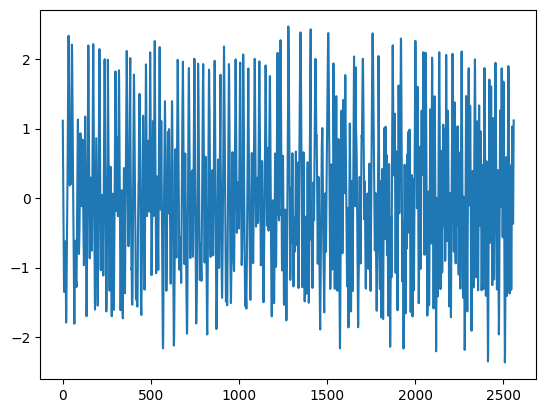

In [16]:
beetlefly_ts = time_series("BeetleFly")
plt.plot(beetlefly_ts)

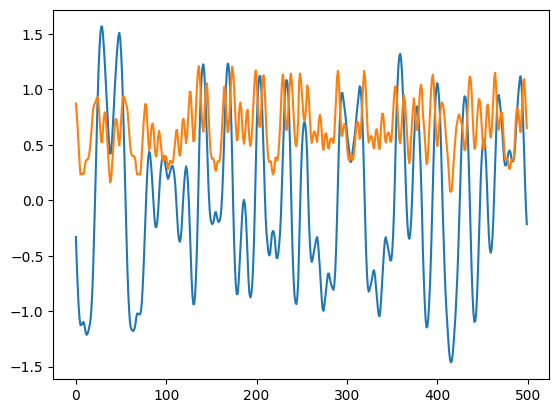

In [17]:
beetlefly_mu, beetlefly_sigma = sliding_mean_stddev(beetlefly_ts, 10)

view_len = 500
plt.plot(beetlefly_mu[:view_len])     # in blue
plt.plot(beetlefly_sigma[:view_len])  # in orange

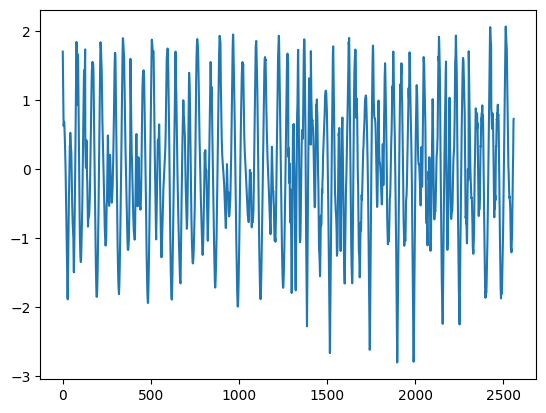

In [18]:
birdchicken_ts = time_series("BirdChicken")
plt.plot(birdchicken_ts)

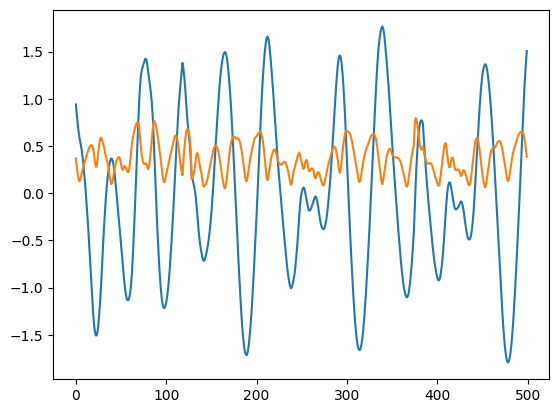

In [19]:
birdchicken_mu, birdchicken_sigma = sliding_mean_stddev(birdchicken_ts, 10)

view_len = 500
plt.plot(birdchicken_mu[:view_len])     # in blue
plt.plot(birdchicken_sigma[:view_len])  # in orange

### Let's look at time series for which the Euclidean distance significantly outperforms the z-normalized Euclidean distance.

In [20]:
dataset_scores.loc[[0, 5]]

,dataset,znormed_euclidean_distance,cinvariant_euclidean_distance,euclidean_distance
0,Adiac,0.80744,0.93578,0.94104
5,Car,0.74170,0.89041,0.90001


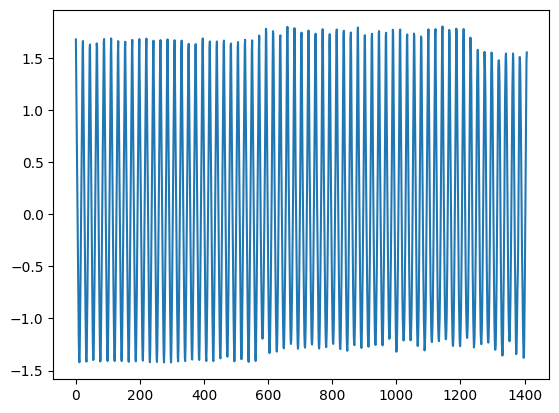

In [21]:
adiac_ts = time_series("Adiac")
plt.plot(adiac_ts)

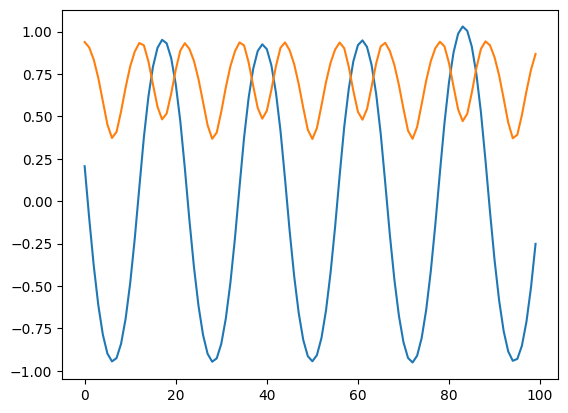

In [22]:
adiac_mu, adiac_sigma = sliding_mean_stddev(adiac_ts, 10)

view_len = 100
plt.plot(adiac_mu[:view_len])     # in blue
plt.plot(adiac_sigma[:view_len])  # in orange

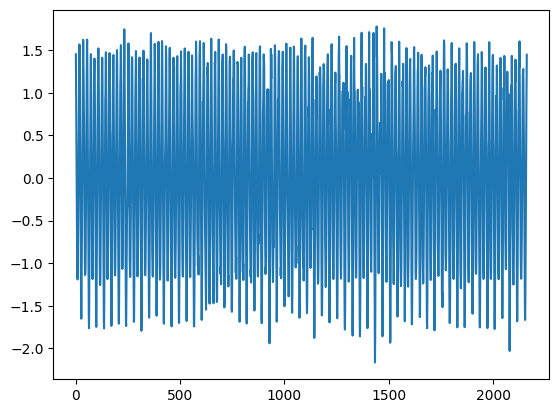

In [23]:
car_ts = time_series("Car")
plt.plot(car_ts)

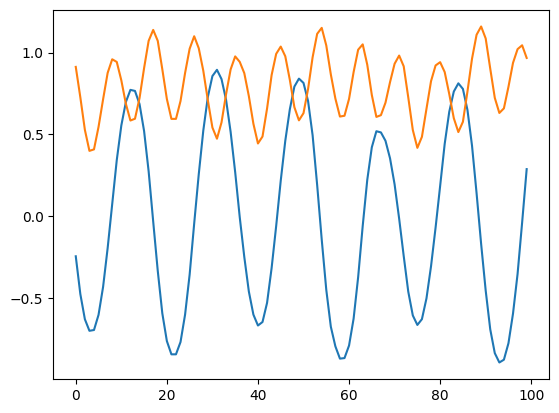

In [24]:
car_mu, car_sigma = sliding_mean_stddev(car_ts, 10)

view_len = 100
plt.plot(car_mu[:view_len])     # in blue
plt.plot(car_sigma[:view_len])  # in orange